# Transfer Learning with Inception Network

One of the most powerful ideas in deep learning is that sometimes we can take knowledge the neural network has learned from one task and apply that knowledge to a separate task. So for example, maybe we could have the neural network learn to recognize objects like cats and then use that knowledge or use part of that knowledge to help us do a better job reading x-ray scans. This is called **transfer learning**. 

Let's say we've trained our neural network on some task. If we want to take this neural network and adapt what is learned to a different task, what we can do is delete the last one or more layers of the neural network, and create several new layers. Depending on how much data we have, we might just retrain the new layers of the network or maybe we could retrain even more layers of this neural network. 

Transfer learning makes sense when we have a lot of data for the problem we're transferring from and usually relatively less data for the problem we're transferring to.

The motivation of **Inception Network** is, instead of picking a filter size or thinking about if we want to use a conv layer or pooling layer, we can do them all and just concatenate all the outputs, and let the network learn whatever parameters it wants to use. To save the computation time, we can use 1x1 convolution to shrink the channel number.

In this notebook, we will use a pre-trained Inception Network for cat-dog classification task.

In [1]:
%matplotlib inline
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import matplotlib.pyplot as plt
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


## 1. Data Pre-Processing

The following python code will use the OS library to use Operating System libraries, giving us access to the file system, and the zipfile library allowing us to unzip the data. 

### 1.1 File Preprocessing

In [2]:
# training and development dataset

zipfile_path = 'data/cats_dogs_train.zip'
zip_file = zipfile.ZipFile(zipfile_path, 'r') # Open a ZIP file
zip_file.extractall(path = 'data/') # Extract all members from the archive
zip_file.close() # Close the archive file

zipfile_path = 'data/cats_dogs_validation.zip'
zip_file = zipfile.ZipFile(zipfile_path, 'r') # Open a ZIP file
zip_file.extractall(path = 'data/') # Extract all members from the archive
zip_file.close() # Close the archive file

The contents of the .zip are extracted to the base directory `data/cats_and_dogs_filtered/train` (for training) and `data/cats_and_dogs_filtered/validation` (for development), which in turn each contains `cats` and `dogs` subdirectories.

We do not explicitly label the images as cats or dogs. We'll use Image Generator -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. 

In [3]:
# Directory with our training cat pictures
train_cat_dir = os.path.join('data/cats_dogs_train/train/cats')
train_cat_names = os.listdir(train_cat_dir)
# Directory with our training dog pictures
train_dog_dir = os.path.join('data/cats_dogs_train/train/dogs')
train_dog_names = os.listdir(train_dog_dir)
# Directory with our dev cat pictures
dev_cat_dir = os.path.join('data/cats_dogs_validation/validation/cats')
dev_cat_names = os.listdir(dev_cat_dir)
# Directory with our dev dog pictures
dev_dog_dir = os.path.join('data/cats_dogs_validation/validation/dogs')
dev_dog_names = os.listdir(dev_dog_dir)

Let's find out the total number of cat and dog images in the directories.

In [4]:
print('total training cat images:', len(train_cat_names))
print('total training dog images:', len(train_dog_names))
print('total dev cat images:', len(dev_cat_names))
print('total dev dog images:', len(dev_dog_names))

total training cat images: 1000
total training dog images: 1000
total dev cat images: 500
total dev dog images: 500


### 1.2 Image Data Examples
Now let's take a look at a few pictures to get a better sense of what they look like.

In [5]:
# we'll output images in a nrows x ncols configuration

nrows = 4
ncols = 4

train_cat_paths = [os.path.join(train_cat_dir, fname) for fname in train_cat_names]
train_dog_paths = [os.path.join(train_dog_dir, fname) for fname in train_dog_names]
dev_cat_paths = [os.path.join(dev_cat_dir, fname) for fname in dev_cat_names]
dev_dog_paths = [os.path.join(dev_dog_dir, fname) for fname in dev_dog_names]

Display a batch of 8 cat and 8 dog pictures.

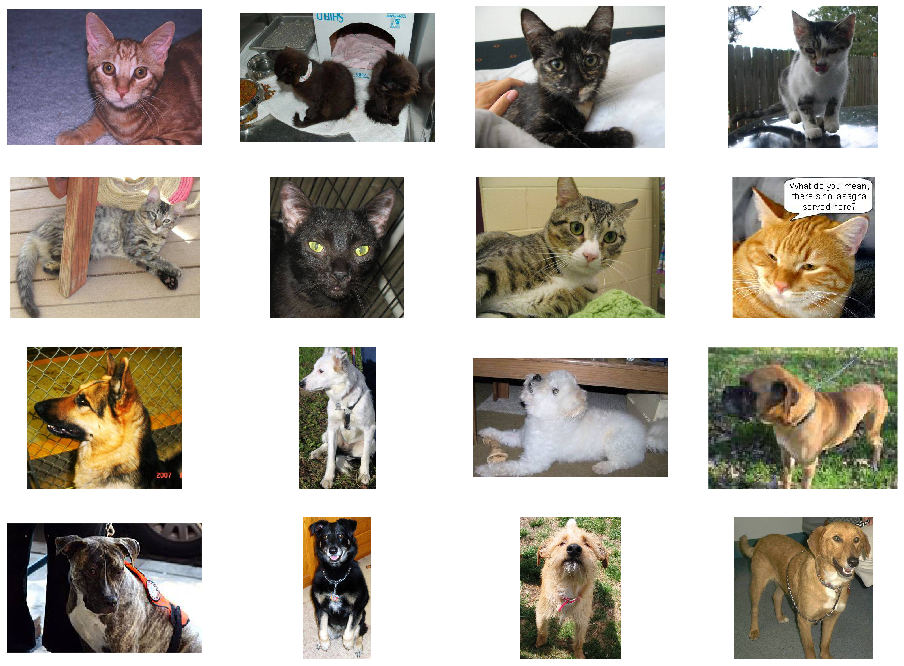

In [6]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

# iterating over 16 images
for i, img_path in enumerate(train_cat_paths[10:14] + dev_cat_paths[10:14] + train_dog_paths[10:14] + dev_dog_paths[10:14]):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img)

### 1.3. Image Data Augmentation and Generator 

In [7]:
# create image data

# training set with image data augmentation
train_gen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')
train_generator = train_gen.flow_from_directory(
        'data/cats_dogs_train/train/', 
        target_size = (150, 150),  # All images will be resized to this dimension
        batch_size = 20,
        class_mode = 'binary')

# dev set
dev_gen = ImageDataGenerator(rescale = 1/255)
dev_generator = dev_gen.flow_from_directory(
        'data/cats_dogs_validation/validation/',  
        target_size = (150, 150),  # All images will be resized to this dimension
        batch_size = 20,
        class_mode = 'binary')

# print class indices
print("Class index: "  + str(train_generator.class_indices))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class index: {'cats': 0, 'dogs': 1}


## 2. Transfer Learning

We use an **Inception Model** pre-trained with a large data set. We will create new layers on top of the 'mixed7' layer.

Note that because we are facing a two-class classification problem, i.e. a **binary classification problem**, we will end our network with a **sigmoid** activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [8]:
model_pretrained = InceptionV3(include_top = False, # do not include the fully-connected layer
                              input_shape = (150, 150, 3), 
                              weights = None)

# load the weights
model_pretrained.load_weights('model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# To freeze keras layers, set the trainable property of a layer to True or False after instantiation. 
for layer in model_pretrained.layers:
    layer.trainable = False
    
# get the output from a specific layer, we will start from this layer
model_pretrained_out = model_pretrained.get_layer('mixed7')
print('Pre-trained model output shape:', model_pretrained_out.output_shape)

Pre-trained model output shape: (None, 7, 7, 768)


In [9]:
# complete model

# output from pre-trained model
x = model_pretrained_out.output
# flatten the results to feed into a DNN
x = layers.Flatten()(x)
# 1024 neuron hidden layer
x = layers.Dense(1024, activation='relu')(x)
# add a drop out layer
x = layers.Dropout(rate = 0.2)(x)
# Only 1 output neuron. It will contain a value from 0-1 where 0 for 'cats' and 1 for 'dogs'
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs = model_pretrained.input, outputs = x)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

We will train our model with the `binary_crossentropy` loss. We will use the `RMSprop` optimizer with a learning rate of `0.0001`. During training, we will want to monitor classification accuracy.

In [11]:
model.compile(loss = 'binary_crossentropy',
              optimizer = RMSprop(lr = 1e-4),
              metrics = ['acc'])

## 3. Model Training

In [12]:
# A callback is a set of functions to be applied at given stages of the training procedure. 
# We can use callbacks to get a view on internal states and statistics of the model during training. 
# We can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential 
# or Model classes. 
# The relevant methods of the callbacks will then be called at each stage of the training.

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') > 0.98):
            print("\nReached target accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [13]:
# create function to plot the training progress

def plot_progress(history, title):
    """
    Plot the loss and accuracy of training and validation data, as functions of epochs
    
    Arguments:
    history: the History object returned by model.fit_generator() 
    title: the title of the graph 
    """

    train_loss = history.history['loss']
    train_acc = history.history['acc']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_acc']
    epochs = range(len(train_acc))
    
    fig, axes = plt.subplots(1, 2)
    fig.suptitle(title, fontsize = 20)
    fig.set_size_inches(16, 5)
    axes[0].plot(epochs, train_acc, 'bo', label = 'Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
    axes[0].set_title('Accuracy')
    axes[0].legend()
    axes[1].plot(epochs, train_loss, 'bo', label = 'Training Loss')
    axes[1].plot(epochs, val_loss, 'b', label = 'Validation Loss')
    axes[1].set_title('Loss')
    axes[1].legend()
    plt.show()

In [14]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100, # number of images = batch_size * steps
    epochs = 20,
    verbose = 1,
    validation_data = dev_generator,
    validation_steps = 50, # number of images = batch_size * steps
    callbacks = [callbacks])

Epoch 1/20
100/100 [==============================] - 333s 3s/step - loss: 0.4997 - acc: 0.7540 - val_loss: 0.2418 - val_acc: 0.9300
Epoch 2/20
100/100 [==============================] - 336s 3s/step - loss: 0.3901 - acc: 0.8310 - val_loss: 0.1977 - val_acc: 0.9520
Epoch 3/20
100/100 [==============================] - 337s 3s/step - loss: 0.3452 - acc: 0.8530 - val_loss: 0.7065 - val_acc: 0.8820
Epoch 4/20
100/100 [==============================] - 334s 3s/step - loss: 0.3446 - acc: 0.8485 - val_loss: 0.2513 - val_acc: 0.9470
Epoch 5/20
100/100 [==============================] - 343s 3s/step - loss: 0.3040 - acc: 0.8815 - val_loss: 0.3460 - val_acc: 0.9380
Epoch 6/20
100/100 [==============================] - 343s 3s/step - loss: 0.3044 - acc: 0.8720 - val_loss: 0.2357 - val_acc: 0.9560
Epoch 7/20
100/100 [==============================] - 338s 3s/step - loss: 0.2954 - acc: 0.8855 - val_loss: 0.3639 - val_acc: 0.9410
Epoch 8/20
100/100 [==============================] - 337s 3s/step - 

#### Plot the training progress

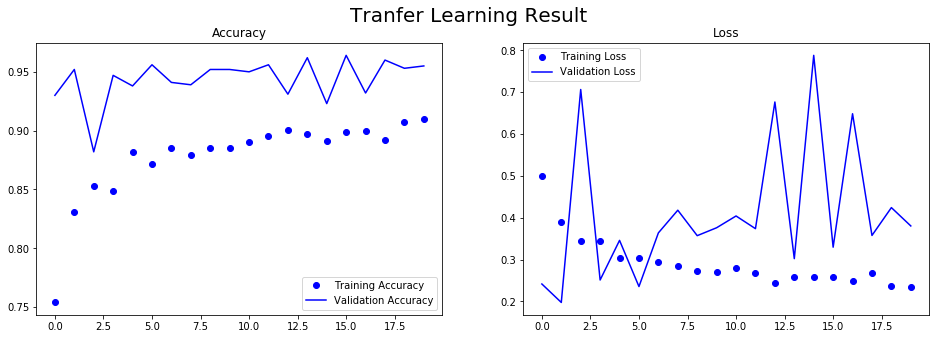

In [15]:
plot_progress(history, 'Tranfer Learning Result')

## 4. Model Testing

Let's now take a look at actually running a prediction using the model. This code will allow us to choose 1 or more files from our file system, it will then upload them, and run them through the model, giving an indication of whether the object is a cat or a dog.

Our images are downloaded from https://pixabay.com/

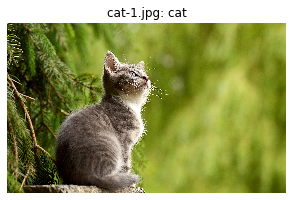

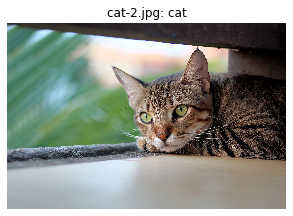

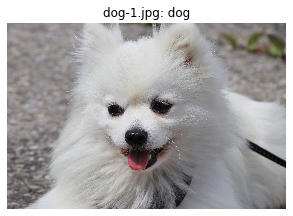

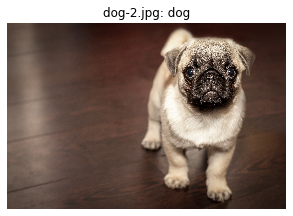

In [16]:
test_path = 'test/' # the folder that saves the test images
test_files = [os.path.join(test_path, fname) for fname in os.listdir(test_path)]

for file in test_files:
    img = image.load_img(file, target_size = (150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x /= 255
    
    # predict
    classes = model.predict(x)
    
    # show the figure with prediction
    image_cur = plt.imread(file)
    plt.figure(figsize = (5, 5))
    plt.imshow(image_cur)
    plt.axis('off')
    if classes[0] > 0.5:
        plt.title(file.split('/')[-1] + ": dog")
    else:
        plt.title(file.split('/')[-1] + ": cat")